### Balance Controller

This notebook exemplifies the Balance Controller for quadrupedal robots described in the [MIT Cheetah 3 paper](https://dspace.mit.edu/bitstream/handle/1721.1/126619/IROS.pdf?sequence=2&isAllowed=y)

The balance controller makes use of a Quadratic Program to optimize the ground reaction forces acting on each leg

In [53]:
# imports
import numpy as np
import matplotlib.pyplot as plt

#### PD control of desired state
The desired translational and angular acceleration of the robot's COM is calculated from the desired position and orientation using an PD-controller:

$$
\left( \begin{array}{c}
    \ddot{\textbf{p}}_\mathrm{c, d}\\ 
    \dot{\boldsymbol{\omega}}_\mathrm{b, d}\\ 
    \end{array}
\right)
=
\left( \begin{array}{c}
    \textbf{K}_\mathrm{c, p}(\textbf{p}_\mathrm{c, d}-\textbf{p}_\mathrm{c})+\textbf{K}_\mathrm{c, d}(\dot{\textbf{p}}_\mathrm{c, d}-\dot{\textbf{p}}_\mathrm{c})\\ 
    \textbf{K}_\mathrm{b, \omega}\mathrm{log}(\textbf{R}_\mathrm{d}\textbf{R}^T)+\textbf{K}_\mathrm{b, \omega}(\boldsymbol{\omega}_\mathrm{b, d}-\boldsymbol{\omega})\\ 
    \end{array}
\right)
$$

Where the desired rotation is expressed in ration matrices and the error in rotation is calculated using the [matrix logarithm](https://en.wikipedia.org/wiki/Logarithm_of_a_matrix)


The result of the PD controller is used to describe the optimal state (using the state model derived in another notebook[<sup>1</sup>](#fn1)):

$$
\textbf{b}_\mathrm{d}
=
\left( \begin{array}{c}
    m(\ddot{\textbf{p}}_\mathrm{c, d}+\textbf{g})\\ 
    \textbf{I}_\mathrm{G}\dot{\boldsymbol{\omega}}_\mathrm{b, d}\\ 
    \end{array}
\right)
$$


#### Optimization of leg forces

Using the linear state model $\textbf{A}\,\textbf{f}=\textbf{b}_\textrm{d}$, a Quadratic Program is used to calculate the optimat forces to reach the desired state:

$$
\begin{equation}
\begin{aligned}
\min_{\textbf{f}} \quad & (\textbf{Af}-\textbf{b}_\textrm{d})^T \,\textbf{S}\,(\textbf{Af}-\textbf{b}_\textrm{d})\\
\quad & +\alpha\,\lVert \textbf{F} \rVert^2 \\
\quad &+\beta\,\lVert \textbf{F} - \textbf{F}_\mathrm{prev}^* \rVert^2\\
\textrm{s.t.}\quad &  \textbf{C}\,\textbf{f} \leq \textbf{d} \\
\end{aligned}
\end{equation}
$$

where $\alpha$ and $\beta$ are weight the penalization of high forces and deviations to the last solution. The matrix $\textbf{S}$ weights the priority of translational/rotational motion.

The constraints $\textbf{C}\,\textbf{f} \leq \textbf{d}$ ensure the feasibility of the solution and that the solution lies within the friction pyramid. It is important to note that these constraints change according to the current leg state (swing or stance)

#### Constraints
###### 1) Friction Cones/ Pyramids
According to Coulomb lab, dry friction can be described with:

$$
\mathrm{F_t}\leq\mu\mathrm{F_n}
$$
    
Applying this to the quadruped robot, the force exerted tangential to the surface must be smaller or equal than the force exerted normal to the surface times $\mu$. Concluding, there exists a certain angle relative to the ground at which the tangential force gets to high and the leg starts to slip.

We can illustrate this using force vectors directed on the same points but with different angles:

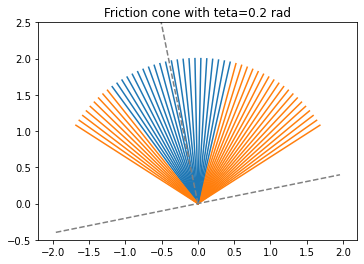

In [54]:
# constants
N = 50
angles = np.linspace(-1, 1, N)
mu = 0.5

# plane angle
teta = 0.2 # in RAD
# unit vectors
et = np.array([ np.cos(teta), np.sin(teta)])
en = np.array([-np.sin(teta), np.cos(teta)])

# plot all force vectors
for a in angles:
    # create different force vectors
    f = np.array([-2*np.sin(a), 2*np.cos(a)])
    # split into components (assuming flat ground)
    ft = np.linalg.norm(f@et)
    fn = np.linalg.norm(f@en)
    # define color depending in Coulomb inequality
    c = ("tab:blue" if ft <= mu*fn else "tab:orange")
    # create a vector to be plotted
    plt.plot([0, f[0]], [0, f[1]], color=c)

# plot plane
plt.plot([-2*et[0], 2*et[0]], [-2*et[1], 2*et[1]], "--", color="gray")
plt.plot([       0, 3*en[0]], [       0, 3*en[1]], "--", color="gray")
    
plt.title(f"Friction cone with teta={teta} rad")
plt.xlim(-2.2, 2.2)
plt.ylim(-0.5, 2.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

The blue force vectors satisfy the coulomb inequality, while the orange vectors don't. Transferred onto the robot this means that if the robot would place his leg in such a way that the resulting ground reaction force would not lie within the friction cone (orange area), the robot would start to slip.

In 3D, the plot above would look like a cone, hence the name. In order to simplify this model for calculations, a linearized version can be used, the so called _friction pyramid_. 

The constraints become:

$$
-\mu (\textbf{f}_\mathrm{n}\,\cdot\,\textbf{n})\,\leq\,\textbf{f}_\mathrm{n}\cdot\textbf{t}_\mathrm{x}\,\leq\,\mu (\textbf{f}_\mathrm{n}\,\cdot\,\textbf{n})
$$
$$
-\mu (\textbf{f}_\mathrm{n}\,\cdot\,\textbf{n})\,\leq\,\textbf{f}_\mathrm{n}\cdot\textbf{t}_\mathrm{y}\,\leq\,\mu (\textbf{f}_\mathrm{n}\,\cdot\,\textbf{n})
$$

where $\textbf{n}$ denotes the normal to the plane and $\textbf{t}_\mathrm{x}$, $\textbf{t}_\mathrm{y}$ are tangential vectors in x and y directions and $\textbf{f}_\mathrm{n}$ is the force vector of foot n.

More information and better plots on this topic [here](https://scaron.info/teaching/friction-cones.html)

###### 2) Feasibility
There are a few conditions to keep the result of the optimization attainable in reality. 

2.1) Leg cannot pull the ground, they can only push. The ground reaction force must be zero or positive
$$
\textbf{f}_\mathrm{n}\,\cdot\,\textbf{n} \geq 0
$$

2.2) There exists a maximum torque that can be exerted by the motors. While the effect on the corresponding maximum ground force depends on the current configuration, it makes sense to set a general limit to simplify the optimization.
$$
\textbf{f}_\mathrm{n} \leq \textbf{f}_\mathrm{max}
$$

2.3) It makes sense to restrict the output of the PD-controller to keep accelerations feasible and prevent gimbal lock
$$
\left( \begin{array}{c}
    \ddot{\textbf{p}}_\mathrm{c, d}\\ 
    \dot{\boldsymbol{\omega}}_\mathrm{b, d}\\ 
    \end{array}
\right)
\leq
\left( \begin{array}{c}
    \ddot{\textbf{p}}_\mathrm{c, max}\\ 
    \dot{\boldsymbol{\omega}}_\mathrm{b, max}\\ 
    \end{array}
\right)
$$

$$
\boldsymbol{\omega}_\mathrm{b} \leq \boldsymbol{\omega}_\mathrm{b, max}
$$

###### 3) Resulting constrains
$\textbf{C}$ has the shape of:
$$
\textbf{C} = 
\left( 
\begin{array}{cccc}
    \textbf{C}_0 & \textbf{0}_{8\times 3} & \textbf{0}_{8\times 3} & \textbf{0}_{8\times 3}\\ 
    \textbf{0}_{8\times 3} & \textbf{C}_1 & \textbf{0}_{8\times 3} & \textbf{0}_{8\times 3}\\
    \textbf{0}_{8\times 3} & \textbf{0}_{8\times 3} & \textbf{C}_2 & \textbf{0}_{8\times 3}\\
    \textbf{0}_{8\times 3} & \textbf{0}_{8\times 3} & \textbf{0}_{8\times 3} & \textbf{C}_3\\
\end{array}
\right)
$$

Where each single $\textbf{C}_\mathrm{n}$ according to the above defined criteria:
$$
\textbf{C}_\mathrm{n} = 
\left( 
\begin{array}{c}
    (-\mu\textbf{n} + \textbf{t}_x)^T\\ 
    (\mu\textbf{n} + \textbf{t}_x)^T\\
    (-\mu\textbf{n} + \textbf{t}_y)^T\\
    (\mu\textbf{n} + \textbf{t}_y)^T\\
    -\textbf{n}^T\\
    \textbf{I}_{3\times 3}\\
\end{array}
\right)
$$

with the correcponding vector $\textbf{d}$:
$$
\textbf{d} = 
\left( 
\begin{array}{c}
    \textbf{d}_0\\
    \textbf{d}_1\\ 
    \textbf{d}_2\\ 
    \textbf{d}_3\\ 
\end{array}
\right)
$$

including

$$
\textbf{d}_\mathrm{n} = 
\left( 
\begin{array}{c}
    \textbf{0}_\mathrm{5\times1}\\
    \textbf{f}_\mathrm{max}
\end{array}
\right)
$$



##### Calculation
Finaly it is possible to make an example calculation. Firstly, a system model is generated:

In [55]:
# constants
m = 1
mu = 0.2
g = np.array([0, 0, 9.81])
I_g = np.eye(3)
I_3 = np.eye(3)

# desired state
ddp_cd = np.array([0, 0, 0])
do_bd = np.array([0, 0, 0])
b_d = np.vstack((m*(ddp_cd + g),
                 I_g@do_bd)
               )

# generate system matrix (see State_Model.ipynb)
def skew(r):
    '''return the skew symmetric matrix corresponding to r'''
    return np.array([[    0, -r[2],  r[1]],
                     [ r[2],     0, -r[0]],
                     [-r[1],  r[0],    0]])

# leg and COM location
p0 = np.array([ 0.09,  0.04, 0.18]) # support
p1 = np.array([ 0.09, -0.04, 0.14]) # swing
p2 = np.array([-0.09,  0.04, 0.14]) # swing
p3 = np.array([-0.09, -0.04, 0.18]) # support
pc = np.array([0, 0, 0])

# generate A
A = np.vstack((np.hstack((        I_3,         I_3,         I_3,        I_3)),
               np.hstack((skew(p0-pc), skew(p1-pc), skew(p2-pc), skew(p3-pc))))
             )

Now we can set up the constraints

In [56]:
O_83 = np.zeros((8,3))
O_51 = np.zeros(5)
n = np.array([0, 0, 1])
ty = np.array([0, 1, 0])
tx = np.array([1, 0, 0])
f_max = np.array([1, 1, 1])*m*9.81

C_n = np.vstack((np.transpose(-mu*n+tx),
                 np.transpose( mu*n+tx),
                 np.transpose(-mu*n+ty),
                 np.transpose( mu*n+ty),
                 np.transpose(n),
                 I_3)
               )

C = np.block([[C_n,  O_83, O_83, O_83],
              [O_83, C_n,  O_83, O_83],
              [O_83, O_83, C_n,  O_83],
              [O_83, O_83, O_83, C_n]])

d_n = np.hstack((O_51, f_max)).T
d = np.hstack((d_n, d_n, d_n, d_n))

# test shapes
ft = np.zeros(12)
qw = C@ft
print(d.shape, qw.shape)

(32,) (32,)


#### Footnotes
<sup>1</sup>: <span id="fn1">See [`State_Model.ipynb`](https://github.com/ThomasSchnapka/quaro/blob/master/notebooks/State_Model.ipynb)</span>

#### Sources
- Bledt, Gerado: Regularized Predictive Control Framework for
Robust Dynamic Legged Locomotion
- Bledt, Gerado et al: MIT Cheetah 3: Design and Control of a Robust,
Dynamic Quadruped Robot
- Focchi, Michele: [Course Control of Legged Robots](https://www.youtube.com/user/mfocchichannel/videos)
- https://en.wikipedia.org/wiki/Friction#Dry_friction
- https://scaron.info/teaching/friction-cones.html